In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 9, 23, 21, 52, 56, 603958)

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1048724
2024-09-23 21:53:00,834 WARNING: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead

2024-09-23 21:53:00,837 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
saved_model_dir

'C:\\Users\\chidu\\AppData\\Local\\Temp\\2edc0e4c-9919-4bd8-b53d-90ca5594cd76\\air_quality_xgboost_model/1'

In [7]:
local_model_dir = "./air_quality_model"

retrieved_xgboost_model = XGBRegressor() 

retrieved_xgboost_model.load_model(local_model_dir + "/model.json")

In [8]:
retrieved_xgboost_model

XGBRegressor(base_score='1.01333336E2', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-09-24 00:00:00+00:00,28.299999,0.0,8.427383,109.983192,abuja
1,2024-09-28 00:00:00+00:00,26.750000,0.1,5.116561,140.710617,abuja
2,2024-09-29 00:00:00+00:00,27.350000,0.1,2.968636,165.963730,abuja
3,2024-09-25 00:00:00+00:00,24.400000,0.3,8.473393,167.735245,abuja
4,2024-09-27 00:00:00+00:00,27.450001,0.0,2.305125,308.659821,abuja
5,2024-09-26 00:00:00+00:00,28.900000,0.0,8.825508,168.231735,abuja
6,2024-10-01 00:00:00+00:00,27.900000,0.1,6.489992,183.179764,abuja
7,2024-10-02 00:00:00+00:00,29.650000,0.0,5.154416,167.905258,abuja
8,2024-09-30 00:00:00+00:00,27.500000,0.0,6.214563,169.992081,abuja


In [10]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-09-24 00:00:00+00:00,28.299999,0.0,8.427383,109.983192,abuja,137.577759
1,2024-09-28 00:00:00+00:00,26.750000,0.1,5.116561,140.710617,abuja,91.022049
2,2024-09-29 00:00:00+00:00,27.350000,0.1,2.968636,165.963730,abuja,103.717407
3,2024-09-25 00:00:00+00:00,24.400000,0.3,8.473393,167.735245,abuja,81.685165
4,2024-09-27 00:00:00+00:00,27.450001,0.0,2.305125,308.659821,abuja,81.149788
5,2024-09-26 00:00:00+00:00,28.900000,0.0,8.825508,168.231735,abuja,149.114792
6,2024-10-01 00:00:00+00:00,27.900000,0.1,6.489992,183.179764,abuja,87.395981
7,2024-10-02 00:00:00+00:00,29.650000,0.0,5.154416,167.905258,abuja,142.790222
8,2024-09-30 00:00:00+00:00,27.500000,0.0,6.214563,169.992081,abuja,146.799835


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 456.0+ bytes


In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-09-24 00:00:00+00:00,28.299999,0.0,8.427383,109.983192,abuja,137.577759,us-embassy,nigeria,1
3,2024-09-25 00:00:00+00:00,24.400000,0.3,8.473393,167.735245,abuja,81.685165,us-embassy,nigeria,4
5,2024-09-26 00:00:00+00:00,28.900000,0.0,8.825508,168.231735,abuja,149.114792,us-embassy,nigeria,6
4,2024-09-27 00:00:00+00:00,27.450001,0.0,2.305125,308.659821,abuja,81.149788,us-embassy,nigeria,5
1,2024-09-28 00:00:00+00:00,26.750000,0.1,5.116561,140.710617,abuja,91.022049,us-embassy,nigeria,2
2,2024-09-29 00:00:00+00:00,27.350000,0.1,2.968636,165.963730,abuja,103.717407,us-embassy,nigeria,3
8,2024-09-30 00:00:00+00:00,27.500000,0.0,6.214563,169.992081,abuja,146.799835,us-embassy,nigeria,9
6,2024-10-01 00:00:00+00:00,27.900000,0.1,6.489992,183.179764,abuja,87.395981,us-embassy,nigeria,7
7,2024-10-02 00:00:00+00:00,29.650000,0.0,5.154416,167.905258,abuja,142.790222,us-embassy,nigeria,8


In [13]:
batch_data.info(
    
)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


Directory ../docs/air_quality/assets/img created.


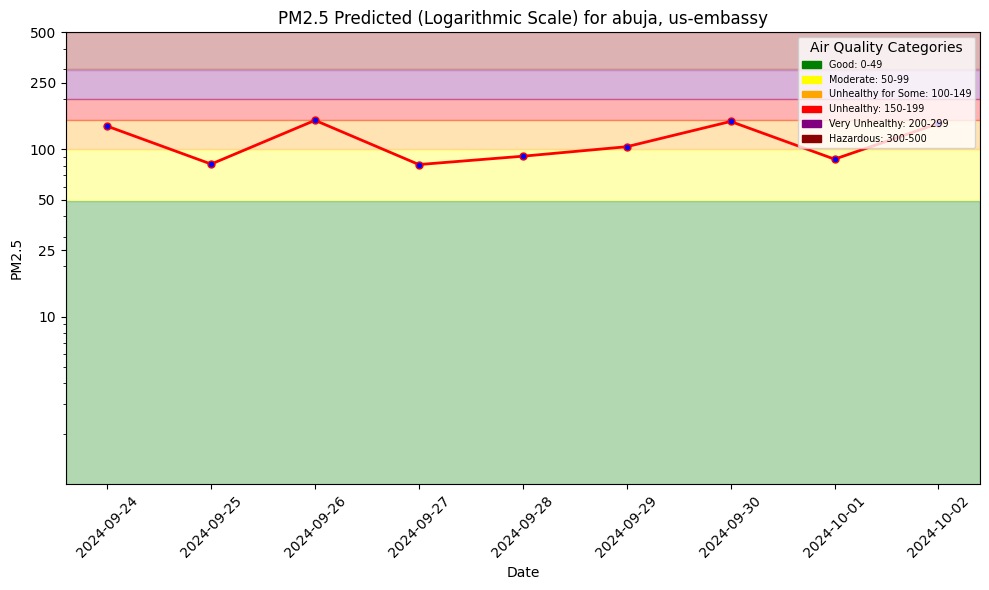

In [14]:
file_path = "../docs/air_quality/assets/img/pm25_forecast.png"

directory = os.path.dirname(file_path)

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory {directory} created.")
else:
    print(f"Directory {directory} already exists.")


plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()  

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1048724/fs/1040451/fg/1215841


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1048724/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x24646072180>, None)

In [17]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-09-24 00:00:00+00:00,28.299999,0.0,8.427383,109.983192,abuja,137.577759,us-embassy,nigeria,1


In [18]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.60s) 


,date,pm25,country,city,street,url
0,2024-07-23 00:00:00+00:00,71.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
1,2022-10-12 00:00:00+00:00,72.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
2,2022-07-11 00:00:00+00:00,68.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
3,2023-03-31 00:00:00+00:00,126.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
4,2023-11-20 00:00:00+00:00,120.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
...,...,...,...,...,...,...
1217,2021-04-02 00:00:00+00:00,176.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
1218,2024-04-24 00:00:00+00:00,88.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
1219,2021-03-19 00:00:00+00:00,160.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449
1220,2024-09-20 00:00:00+00:00,57.0,nigeria,abuja,us-embassy,https://api.waqi.info/feed/@13449


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1048724/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-09-23 00:00:00+00:00,26.799999,0.0,8.913181,223.363464,abuja,147.34079,57.0,us-embassy,nigeria,1


Directory ../docs/air_quality/assets/img already exists.


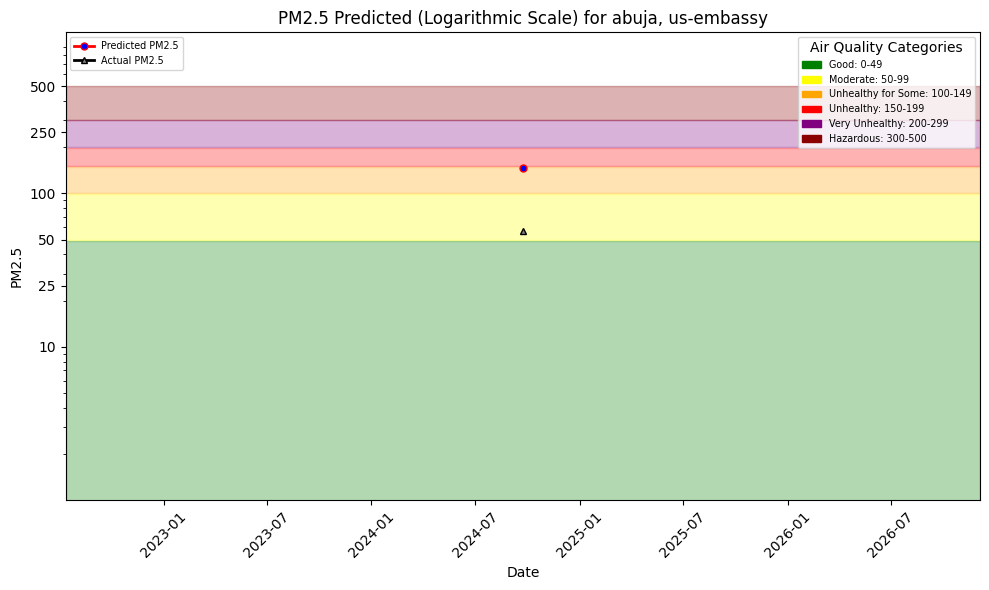

In [20]:
file_path = "../docs/air_quality/assets/img/pm25_hindcast_1day.png"

directory = os.path.dirname(file_path)

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory {directory} created.")
else:
    print(f"Directory {directory} already exists.")

plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()